# IMO - Zadanie 2

Autorzy: Sławomir Gilewski, Dariusz Max Adamski

---

Imports:

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import time
import multiprocessing as mp
from copy import deepcopy
plt.rc('figure', dpi=110, figsize=(9, 5))

Reading instance functions:

In [119]:
# def distance(a, b):
#     return np.round(np.sqrt(np.sum((a - b)**2)))

# def read_instance(path):
#     coords = pd.read_csv(path, sep=' ', names=['n','x','y'], skiprows=6, skipfooter=1, engine='python')
#     cities = coords.drop(columns=['n']).values
#     ns = np.arange(len(cities))
#     cities = np.array([[distance(cities[i], cities[j]) for j in ns] for i in ns])
#     return cities, coords

Drawing functions:

In [120]:
# def draw_path(coords, path, color='blue'):
#     cycle = path + [path[0]]
#     for i in range(len(cycle) - 1):
#         a, b = cycle[i], cycle[i+1]
#         plt.plot([coords.x[a], coords.x[b]], [coords.y[a], coords.y[b]], color=color)

# def plot_solution(coords, solution):
#     path1, path2 = solution
#     draw_path(coords, path1, color='green')
#     draw_path(coords, path2, color='red')
#     plt.scatter(coords.x, coords.y, color='black')
#     plt.show()

Scoring functions:

In [121]:
# def cycle_score(cities, path):
#     cycle = path + [path[0]]
#     return sum(cities[cycle[i], cycle[i+1]] for i in range(len(cycle) - 1))

def score(cities, paths):
    cycle_1 = paths[0] + [paths[0][0]]
    cycle_2 = paths[1] + [paths[1][0]]
    score_1=sum(cities[cycle_1[i], cycle_1[i+1]] for i in range(len(cycle_1) - 1))
    score_2=sum(cities[cycle_2[i], cycle_2[i+1]] for i in range(len(cycle_2) - 1))

    return score_1+score_2

def delta_insert(cities, path, i, city):
    a, b = path[i - 1], path[i]
    return cities[a, city] + cities[city, b] - cities[a, b]



Generating pairs of path indices for local search:

Replacing elements for local search (two cycles and one cycle):

In [122]:
# Score difference after replacing element "i" of path with chosen city
def delta_replace_vertex(cities, path, i, city):
    path_len = len(path)
    a, b, c = path[(i - 1)%path_len], path[i], path[(i+1)%path_len]
    return cities[a, city] + cities[city, c] - cities[a, b] - cities[b, c]

# Score difference after exchanging 2 vertices of 2 different paths on indices i and j
def delta_replace_vertices_outside(cities, paths, i, j):
    return delta_replace_vertex(cities, paths[0], i, paths[1][j]) + delta_replace_vertex(cities, paths[1], j, paths[0][i])

# Score difference after exchanging 2 vertices of the same path on indices i and j
def delta_replace_vertices_inside(cities, path, i, j):
    path_len = len(path)
    a, b, c = path[(i - 1)%path_len], path[i], path[(i+1)%path_len]
    d, e, f = path[(j-1)%path_len], path[j], path[(j+1)%path_len]
    if j-i == 1:
        return cities[a,e]+cities[b,f]-cities[a,b]-cities[e,f]
    elif (i, j) == (0, len(path)-1):
        return cities[e, c] + cities[d, b] - cities[b, c] - cities[d, e]
    else:
        return cities[a,e] + cities[e,c] + cities[d,b] + cities[b,f] -cities[a,b]-cities[b,c]-cities[d,e] - cities[e,f] 

# Score difference after exchanging 2 elements of the same path on edges between i and j
def delta_replace_edges_inside(cities, path, i, j):
    path_len = len(path)
    if (i, j) == (0, len(path)-1):
        a, b, c, d = path[i], path[(i+1)%path_len], path[(j-1)%path_len], path[j]
    else:
        a, b, c, d = path[(i - 1)%path_len], path[i], path[j], path[(j+1)%path_len]
    return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

# generates indices for testing every pair of two paths
def outside_candidates(paths):
    indices = list(range(len(paths[0]))), list(range(len(paths[1])))
    indices_pairwise = list(itertools.product(*indices))
    return indices_pairwise

# generates combinations of all pairs of one path
def inside_candidates(path):
    combinations = []
    for i in range(len(path)):
        for j in range(i+1, len(path)):
            combinations.append([i, j])
    return combinations

def replace_vertices_outside(paths, i, j):
    temp = paths[0][i]
    paths[0][i] = paths[1][j]
    paths[1][j] = temp

def replace_vertices_inside(path, i, j):
    temp = path[i]
    path[i] = path[j]
    path[j] = temp
    
def replace_edges_inside(path, i, j):
    if (i, j) == (0, len(path)-1):
        temp = path[i]
        path[i] = path[j]
        path[j] = temp     
    path[i:j+1] = reversed(path[i:j+1])
    


Initial solvers:

In [123]:
# def solve_regret(args):
#     cities, start = args
#     n = cities.shape[0]
#     remaining = list(range(n))
#     a, b = start, np.argmax(cities[start,:])
#     remaining.remove(a)
#     remaining.remove(b)
#     paths = [[a], [b]]
#     while remaining:
#         for path in paths:
#             scores = np.array([[delta_insert(cities, path, i, v) for i in range(len(path))] for v in remaining])
#             best_city_idx = None
#             if scores.shape[1] == 1:
#                 best_city_idx = np.argmin(scores)
#             else:
#                 regret = np.diff(np.partition(scores, 1)[:,:2]).reshape(-1)
#                 weight = regret - 0.37*np.min(scores, axis=1)
#                 best_city_idx = np.argmax(weight)
                
#             best_city = remaining[best_city_idx]
#             best_insert = np.argmin(scores[best_city_idx])
#             path.insert(best_insert, best_city)
#             remaining.remove(best_city)
#     return paths


def solve_regret(args):
    cities, start_idx = args
    n = cities.shape[0]
    unvisited = list(range(n))
    
    # Choose the starting point for the first cycle
    tour1 = [unvisited.pop(start_idx)]
    nearest_to_first_1 = [cities[tour1[0]][j] for j in unvisited]
    tour1.append(unvisited.pop(np.argmin(nearest_to_first_1)))

    # Choose the furthest city from the starting point as the initial point for the second cycle
    start_city_2_idx = np.argmax([cities[tour1[0]][i] for i in unvisited])
    tour2 = [unvisited.pop(start_city_2_idx)]

    nearest_to_first_2 = [cities[tour2[0]][j] for j in unvisited]
    tour2.append(unvisited.pop(np.argmin(nearest_to_first_2)))

    # Add third point to both tours
    nearest_to_tour_1 = [cities[tour1[0]][j] + cities[tour1[1]][j] for j in unvisited]
    tour1.append(unvisited.pop(np.argmin(nearest_to_tour_1)))

    nearest_to_tour_2 = [cities[tour2[0]][j] + cities[tour2[1]][j] for j in unvisited]
    tour2.append(unvisited.pop(np.argmin(nearest_to_tour_2)))

    # Start adding points that are best fit for the graph
    while len(unvisited) > 0:  # Add when the loop ends
        for tour in [tour1, tour2]:
            regrets = []
            for city in unvisited:
                distances = [cities[tour[i]][city] + cities[city][tour[i+1]] - cities[tour[i]][tour[i+1]] for i in range(len(tour)-1)]
                distances.append(cities[tour[0]][city] + cities[city][tour[-1]] - cities[tour[-1]][tour[0]])
                distances.sort()
                regret = distances[1] - distances[0]
                regret -= 0.37 * distances[0]
                regrets.append((regret, city))
            regrets.sort(reverse=True)
            best_city = regrets[0][1]
            tour_distances = [cities[tour[i]][tour[i+1]] for i in range(len(tour)-1)]
            best_increase = float('inf')
            best_index = -1
            for i in range(len(tour_distances)):
                increase = cities[best_city][tour[i]] + cities[best_city][tour[i+1]] - tour_distances[i]
                if increase < best_increase:
                    best_increase = increase
                    best_index = i + 1
            tour.insert(best_index, best_city)
            unvisited.remove(best_city)
    return [tour1,tour2]

def solve_random(args):
    cities, _ = args
    n = cities.shape[0]
    remaining = list(range(n))
    random.seed(42)
    random.shuffle(remaining)
    paths = [remaining[:n//2], remaining[n//2:]]
    return paths

Greedy (first improvement) local search algorithm:

In [124]:
class GreedySearch(object):
    def __init__(self, cities, variant):
        self.variant = variant
        if variant == "vertices":
            self.delta = delta_replace_vertices_inside
            self.replace = replace_vertices_inside
        else:
            self.delta = delta_replace_edges_inside
            self.replace = replace_edges_inside
        self.cities = cities
        self.moves = [self.outside_vertices_trade_first, self.inside_trade_first]
    
    def outside_vertices_trade_first(self, cities, paths):
        random.seed(42)
        candidates = outside_candidates(paths)
        random.shuffle(candidates)
        for i, j in candidates:
            score_diff = delta_replace_vertices_outside(cities, paths, i, j)
            if score_diff < 0:
                replace_vertices_outside(paths, i, j)
                return score_diff
        return score_diff

    def inside_trade_first(self, cities, paths):
        random.seed(42)
        path_order = random.sample(range(2), 2)
        for idx in path_order:
            candidates = inside_candidates(paths[idx])
            random.shuffle(candidates)
            for i, j in candidates:
                score_diff = self.delta(cities, paths[idx], i, j)
                if score_diff < 0:
                    self.replace(paths[idx], i, j)
                    return score_diff
        return score_diff 
    
    def __call__(self, paths):
        paths = deepcopy(paths)
        # paths = paths.copy()
        random.seed(42)
        start = time.time()
        while True:
            move_order = random.sample(range(2), 2)
            score = self.moves[move_order[0]](self.cities, paths)
            if score >= 0: 
                score = self.moves[move_order[1]](self.cities, paths)
                if score >= 0: 
                    break
        return time.time()-start, paths

Steepest (best improvement) local search algorithm:

In [125]:
class SteepestSearch(object):
    def __init__(self, cities, variant):
        self.variant = variant
        if variant == "vertices":
            self.delta = delta_replace_vertices_inside
            self.replace = replace_vertices_inside
        else:
            self.delta = delta_replace_edges_inside
            self.replace = replace_edges_inside
        self.cities = cities
        self.moves = [self.outside_vertices_trade_best, self.inside_trade_best]
    
    def outside_vertices_trade_best(self, cities, paths):
        candidates = outside_candidates(paths)
        scores = np.array([delta_replace_vertices_outside(cities, paths, i, j) for i, j in candidates])
        best_result_idx = np.argmin(scores)
        if scores[best_result_idx] < 0:
            return replace_vertices_outside, (paths, *candidates[best_result_idx]), scores[best_result_idx]
        return _, _, scores[best_result_idx]
            
    def inside_trade_best(self, cities, paths):
        combinations = inside_candidates(paths[0]), inside_candidates(paths[1])
        scores = np.array([[self.delta(cities, paths[idx], i, j) for i, j in combinations[idx]] for idx in range(len(paths))])
        best_path_idx, best_combination = np.unravel_index(np.argmin(scores), scores.shape)
        best_score = scores[best_path_idx, best_combination]
        if best_score < 0:
            return self.replace, (paths[best_path_idx], *combinations[best_path_idx][best_combination]), best_score
        return _, _, best_score 
    
    def __call__(self, paths):
        paths = deepcopy(paths)
        # paths = paths.copy()
        start = time.time()
        while True:
            replace_funs, args, scores = list(zip(*[move(self.cities, paths) for move in self.moves]))
            best_score_idx = np.argmin(scores)
            if scores[best_score_idx] < 0:
                replace_funs[best_score_idx](*args[best_score_idx])
            else:
                break
        return time.time()-start, paths

Random search algorithm:

In [126]:
class RandomSearch(object):
    def __init__(self, cities, time_limit):
        self.cities = cities
        self.time_limit = time_limit
        self.moves = [self.outside_vertices_trade, self.inside_trade_first_vertices, self.inside_trade_first_edges]
        
    def outside_vertices_trade(self, cities, paths):
        random.seed(42)
        candidates = outside_candidates(paths)
        i, j = random.choice(candidates)
        replace_vertices_outside(paths, i, j)

    def inside_trade_first_vertices(self, cities, paths):
        random.seed(42)
        path_idx = random.choice([0,1])
        candidates = inside_candidates(paths[path_idx])
        i, j = random.choice(candidates)
        replace_vertices_inside(paths[path_idx], i, j)
        
    def inside_trade_first_edges(self, cities, paths):
        random.seed(42)
        path_idx = random.choice([0,1])
        candidates = inside_candidates(paths[path_idx])
        i, j = random.choice(candidates)
        replace_edges_inside(paths[path_idx], i, j)
    
    def __call__(self, paths):
        best_solution = paths
        best_score = score(self.cities, paths)
        paths = deepcopy(paths)
        random.seed(42)
        start = time.time()
        while time.time()-start < self.time_limit:
            move = random.choice(self.moves)
            move(self.cities, paths)
            new_score = score(self.cities, paths)
            if new_score<best_score:
                best_solution = deepcopy(paths)
                best_score = new_score
        return best_solution


In [127]:
def pairwise_distances(points):
    num_points = len(points)
    dist_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = np.linalg.norm(points[i] - points[j])

    return dist_matrix

In [128]:
def plot_optimized_tours(positions, cycle1, cycle2, method):
    # Ensure the cycles start and end at the same city to form closed loops
    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])

    # Plot the optimized tours
    plt.figure()
    plt.plot(positions[cycle1, 0], positions[cycle1, 1], linestyle='-', marker='o', color='r', label='Cycle 1')
    plt.plot(positions[cycle2, 0], positions[cycle2, 1], linestyle='-', marker='o', color='b', label='Cycle 2')

    # Add legend and title
    plt.legend()
    plt.title('Tours - '+method)
    plt.show()

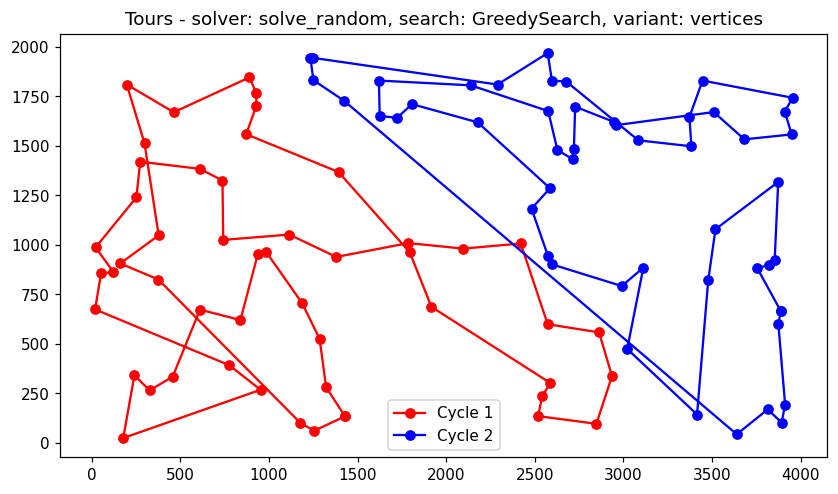

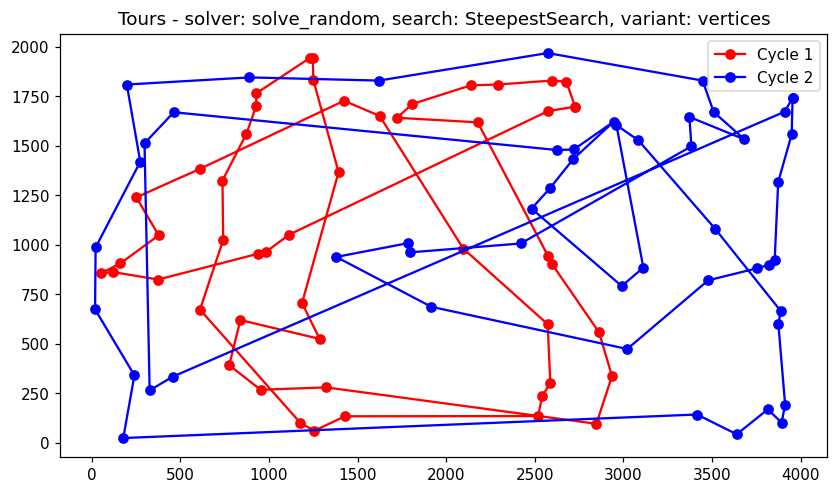

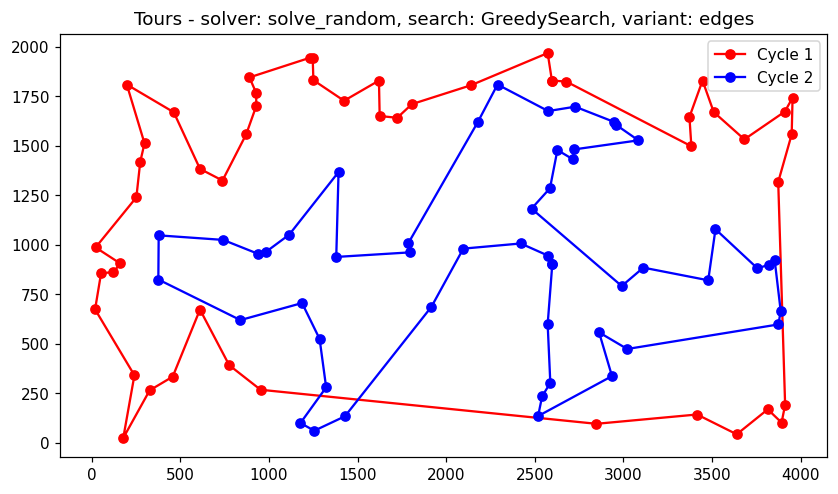

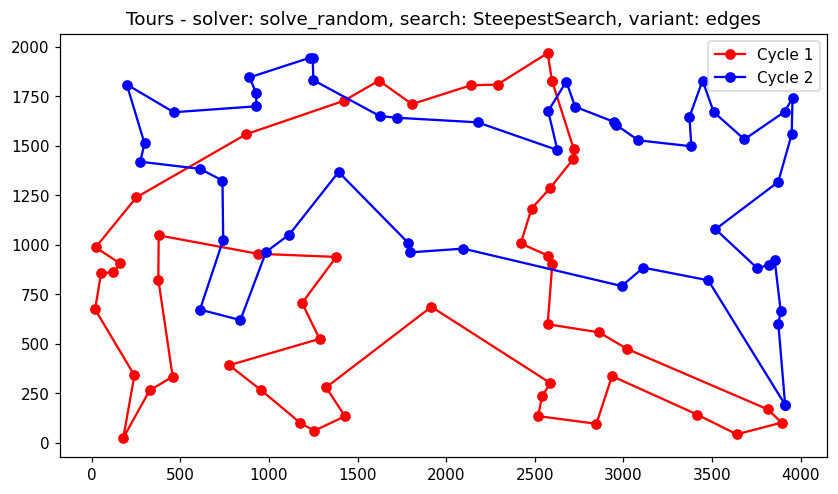

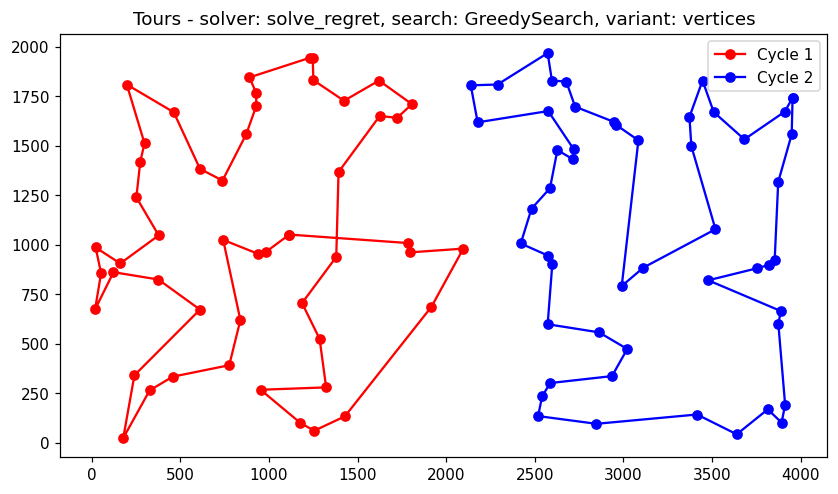

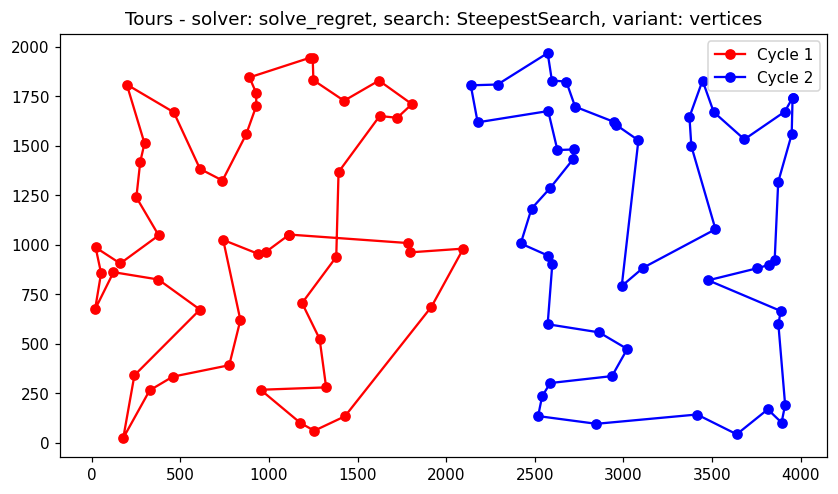

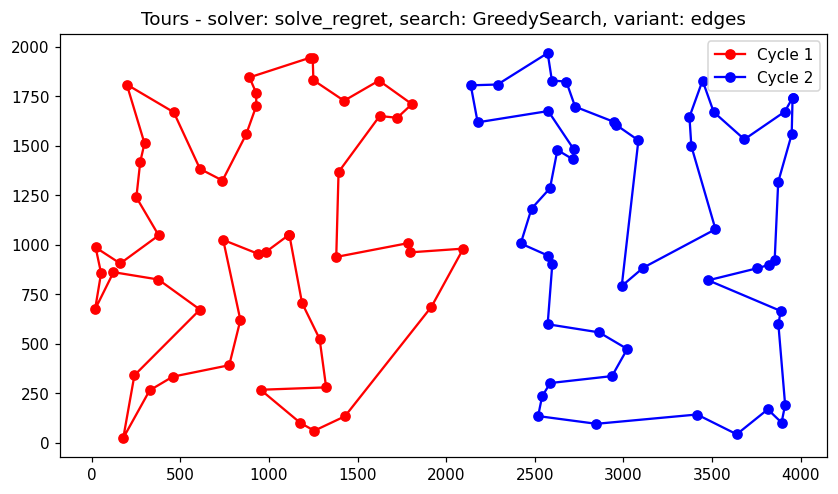

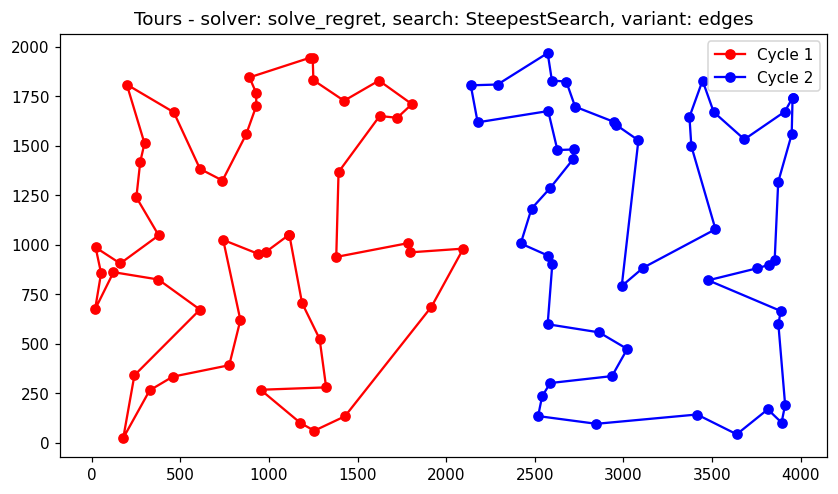

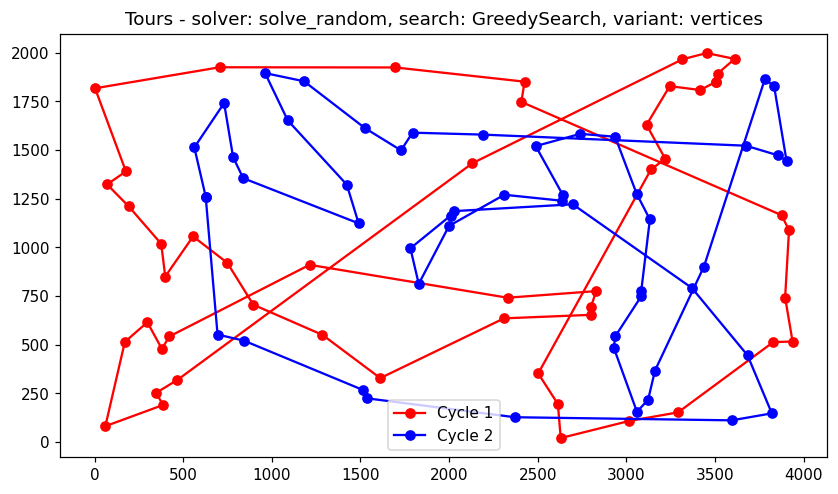

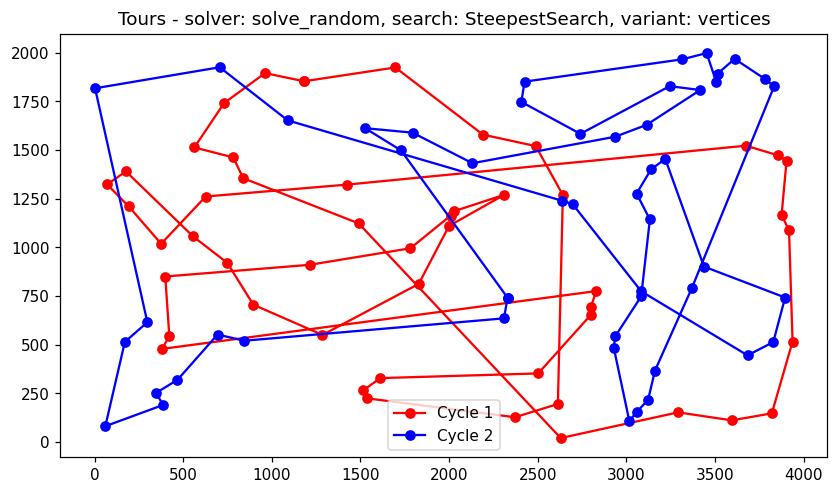

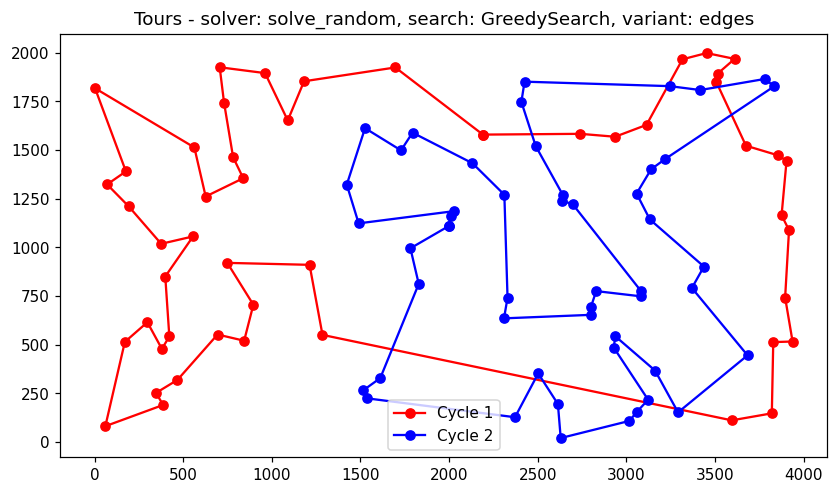

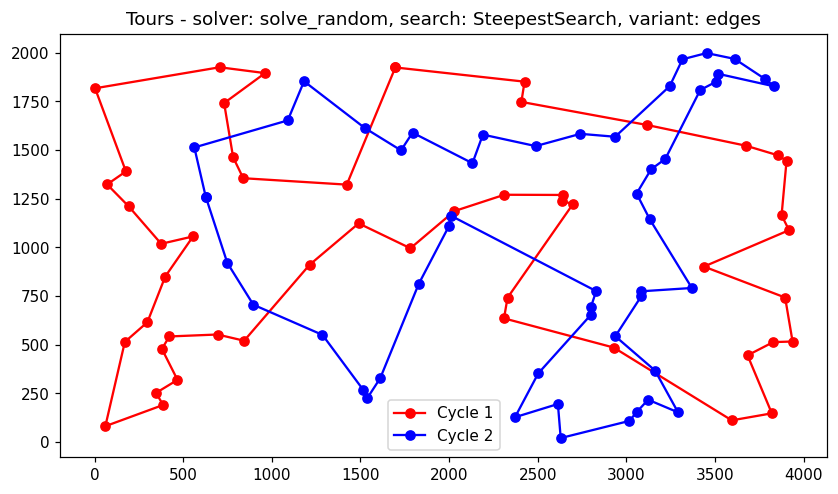

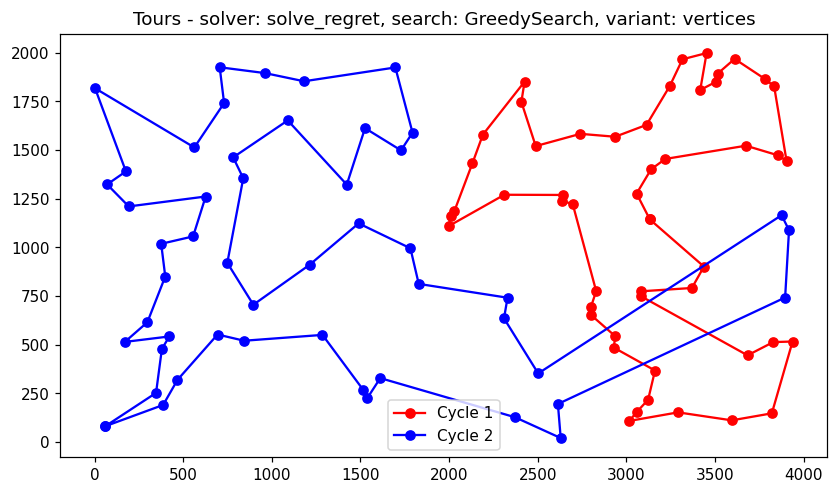

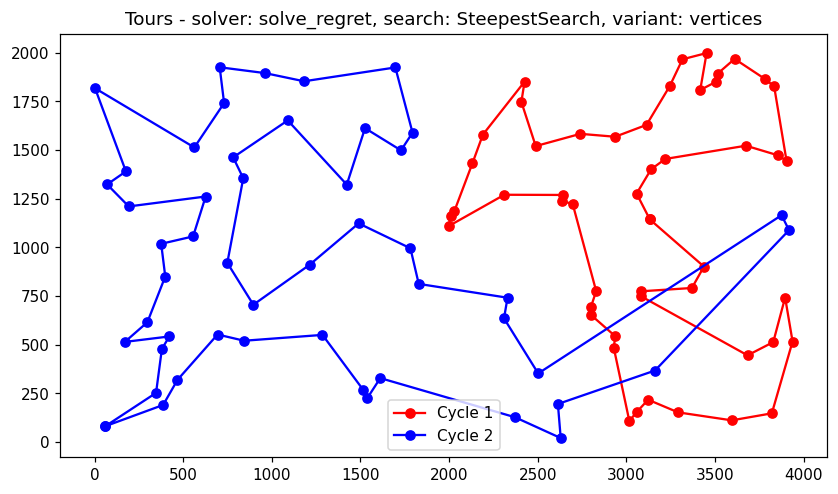

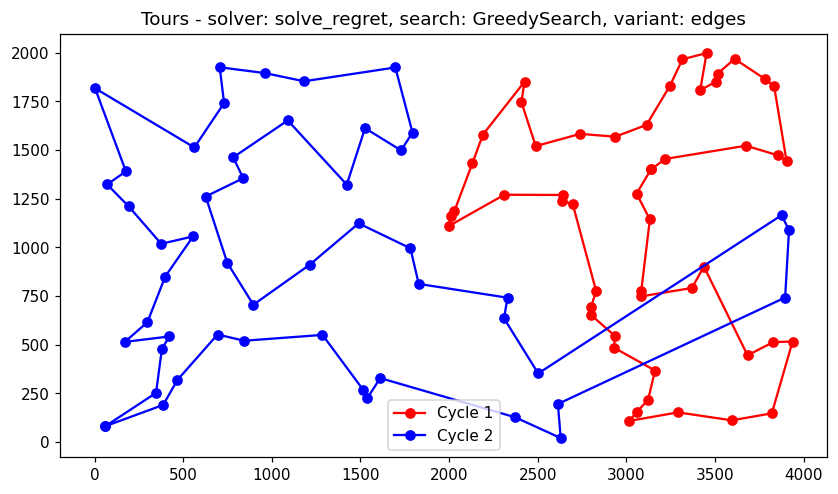

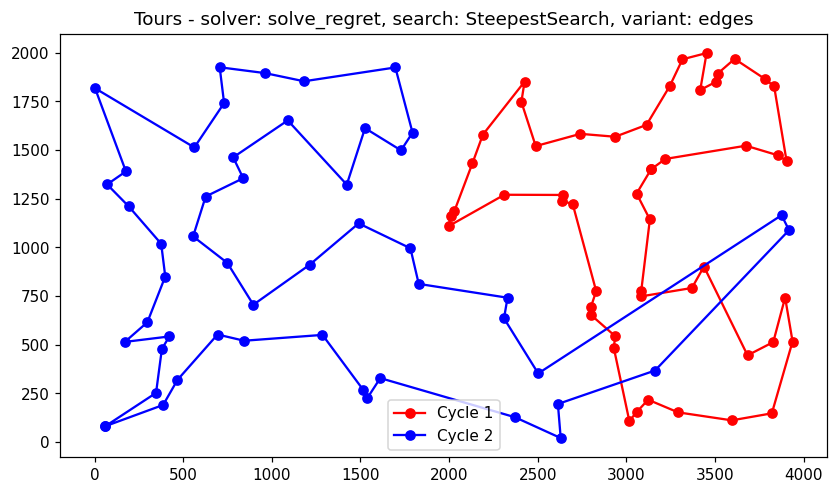

In [129]:
score_results = []
time_results = []
for file in ['kroa.csv','krob.csv']:
    coords = pd.read_csv(file, sep=' ')
    positions=np.array([coords['x'], coords['y']]).T
    cities = np.round(pairwise_distances(np.array(positions)))

    local_variants = [GreedySearch(cities, "vertices"), SteepestSearch(cities, "vertices"), GreedySearch(cities, "edges"), SteepestSearch(cities, "edges")]
    # local_variants = [GreedySearch(cities, "vertices")]
    for solve in [solve_random, solve_regret]:
        solutions = list(map(solve, [(cities, i) for i in range(1)]))
        scores = [score(cities, x) for x in solutions]
        score_results.append(dict(file=file, function=solve.__name__, search="none", variant="none", min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))
        best_idx = np.argmin(scores)
        best = solutions[best_idx]
        # plot_optimized_tours(positions, *best, f'solver: {solve.__name__}, search: None, variant: None')
        for local_search in local_variants:
            times, new_solutions = zip(*list(map(local_search, solutions)))
            new_scores = [score(cities, x) for x in new_solutions]
            best = new_solutions[best_idx]
            plot_optimized_tours(positions, *best, f'solver: {solve.__name__}, search: {type(local_search).__name__}, variant: {local_search.variant}')
            score_results.append(dict(file=file, function=solve.__name__, search=type(local_search).__name__, variant=local_search.variant, min=int(min(new_scores)), mean=int(np.mean(new_scores)), max=int(max(new_scores))))
            time_results.append(dict(file=file, function=solve.__name__, search=type(local_search).__name__,variant=local_search.variant, min=float(min(times)), mean=float(np.mean(times)), max=float(max(times))))
        if solve.__name__ == "solve_random":
            temp_pd = pd.DataFrame(time_results)
            time_limit = max(temp_pd[temp_pd["file"]==file]["mean"])
            random_search = RandomSearch(cities, time_limit)
            random_solutions = list(map(random_search, solutions))
            random_scores = [score(cities, x) for x in random_solutions]
            best = random_solutions[best_idx]
            # plot_optimized_tours(positions, *best, f'solver: {solve.__name__}, search: {type(random_search).__name__}')
            score_results.append(dict(file=file, function=solve.__name__, search=type(random_search).__name__, variant="none", min=int(min(random_scores)), mean=int(np.mean(random_scores)), max=int(max(random_scores))))
scores = pd.DataFrame(score_results)
times = pd.DataFrame(time_results)

In [130]:
scores

,file,function,search,variant,min,mean,max
0,kroa.csv,solve_random,none,none,181748,181748,181748
1,kroa.csv,solve_random,GreedySearch,vertices,31129,31129,31129
2,kroa.csv,solve_random,SteepestSearch,vertices,45777,45777,45777
3,kroa.csv,solve_random,GreedySearch,edges,26829,26829,26829
4,kroa.csv,solve_random,SteepestSearch,edges,27555,27555,27555
5,kroa.csv,solve_random,RandomSearch,none,181729,181729,181729
6,kroa.csv,solve_regret,none,none,23272,23272,23272
7,kroa.csv,solve_regret,GreedySearch,vertices,23218,23218,23218
8,kroa.csv,solve_regret,SteepestSearch,vertices,23170,23170,23170
9,kroa.csv,solve_regret,GreedySearch,edges,23008,23008,23008


In [131]:
times

,file,function,search,variant,min,mean,max
0,kroa.csv,solve_random,GreedySearch,vertices,2.427232,2.427232,2.427232
1,kroa.csv,solve_random,SteepestSearch,vertices,3.253748,3.253748,3.253748
2,kroa.csv,solve_random,GreedySearch,edges,2.019449,2.019449,2.019449
3,kroa.csv,solve_random,SteepestSearch,edges,1.998574,1.998574,1.998574
4,kroa.csv,solve_regret,GreedySearch,vertices,0.063894,0.063894,0.063894
5,kroa.csv,solve_regret,SteepestSearch,vertices,0.086155,0.086155,0.086155
6,kroa.csv,solve_regret,GreedySearch,edges,0.074929,0.074929,0.074929
7,kroa.csv,solve_regret,SteepestSearch,edges,0.069596,0.069596,0.069596
8,krob.csv,solve_random,GreedySearch,vertices,1.901227,1.901227,1.901227
9,krob.csv,solve_random,SteepestSearch,vertices,3.097847,3.097847,3.097847
